# UNET NETWORK (TGS Salt Identification Challenge)

## 1. Import packages

**Import class module of unet model and utility functions of models**

In [1]:
try:
    from models import unet
    from models.util import compute_iou_np, resize_image, binirize_mask
    print("Imported package modules and functions of models from enviroment site package")
except:
    from config import append_path
    append_path('../../')
    from models import unet
    from models.util import compute_iou_np, resize_image, binirize_mask
    print("Imported package modules and functions of models by appending the path of the package to system path")

Imported package modules and functions of models by appending the path of the package to system path


**Import necessary packages and modules**

In [2]:
import os
import random
import math
import json
import pandas as pd
import numpy as np
import tensorflow as tf
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

**Set the random seed of numpy and tensorflow**

In [3]:
# np_rand_seed = random.randint(0,100)
# tf_rand_seed = random.randint(0,100)
np_rand_seed = 56
tf_rand_seed = 62
np.random.seed(np_rand_seed)
print("numpy random seed: ",np_rand_seed)
print("tensorflow random seed: ", tf_rand_seed)

numpy random seed:  56
tensorflow random seed:  62


## 2. Load data

**Set some directories**

In [4]:
# input directory
input_dir = '../../datasets/salt_identification_challenge/'
# directories of train and test images
TRAIN_IMG_DIR = os.path.join(input_dir, 'train')
TEST_IMG_DIR = os.path.join(input_dir, 'test')
# directory of the model files
model_dir = './model_files/'
# directory of submission files
submission_dir = "./submission_files/"
# directory of plot figures
figure_dir = "./model_cost_figures/"

**Inspect the masks of training set**

In [5]:
masks = pd.read_csv(os.path.join(input_dir, "train.csv"))
not_empty = pd.notna(masks.rle_mask)
print(not_empty.sum(), 'masks in', masks[not_empty].id.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.id.nunique(), 'total images')
masks.head(20)

2438 masks in 2438 images
1562 empty images in 4000 total images


id                                           rle_mask
0   575d24d81d                                                NaN
1   a266a2a9df                                          5051 5151
2   75efad62c1  9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3   34e51dba6a  48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4   4875705fb0  1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...
5   782ae9b7e7  1 1815 1819 90 1920 81 2021 73 2122 64 2223 55...
6   9842f69f8d                                                NaN
7   aa94cfb806  1 28 102 28 203 29 304 30 405 32 506 33 607 34...
8   50d3073821                                    1 2121 9293 909
9   28f865caaa                                                NaN
10  b5e1371b3b  75 27 175 28 275 29 374 31 474 32 574 33 674 3...
11  57e394bc67                                                NaN
12  b45ad3932e  49 11 149 11 249 11 351 10 452 9 553 9 654 8 7...
13  ef51bbcde7                                                NaN
14  d4d34af4f7                                          8788 1414
15  302ea1ac81  6 96 108 95 210 94 311 94 413 93 515 92 615 93...
16  40dcff68b3  3536 4 3637 20 3738 36 3839 53 3940 70 4041 86...
17  7845115d01                                          7677 2525
18  3da729cae9  1 54 102 54 203 53 304 53 405 53 506 53 607 53...
19  d67e3a11d8                                                NaN

**Extract ids of train images**

In [6]:
train_ids = masks.id.values
train_ids = np.array(train_ids)

**Extract ids of test images**

In [7]:
test_ids = os.listdir(TEST_IMG_DIR+"/images")
test_ids = np.array(test_ids)

In [8]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 128, 128, 3

## 3. Create functions

**A function to generate train/test image and mask batch**

In [9]:
def generate_batch(indices, ids, IMG_DIR, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, MAX, train_set = False):
    
    '''
    A function to generate train/test image batch
    '''
    # ignore warning
    import warnings
    warnings.filterwarnings('ignore')
    
    # extract the id based of train/test set
    batch_ids = ids[indices]
    
    # initialize numpy arrays to hold images and masks 
    X = np.zeros((len(batch_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
    Y = np.zeros((len(batch_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
    
    # iterate through each image
    for n, id_ in enumerate(batch_ids):        
        # construct path for the image
        if train_set:
            img_path = IMG_DIR+"/images/"+id_+".png"
        else:
            img_path = IMG_DIR+"/images/"+id_
        # load image 
        img = imread(img_path)
        # resize image
        if img.shape[0] != IMG_HEIGHT or img.shape[0] != IMG_WIDTH: 
            img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        # store the image in the designated numpy array
        X[n] = img.astype(np.float32)
        # del image to save runtime memory
        del(img)
        # if train set is wanted
        if train_set:
            mask_path = IMG_DIR+"/masks/"+id_+".png"
            # extract mask
            mask = imread(mask_path, as_gray=True)
            # divide the mask by maximum value
            mask = mask/MAX
            # resize mask
            if mask.shape[0] != IMG_HEIGHT or mask.shape[1] != IMG_WIDTH: 
                mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            # expand dimension
            mask = np.expand_dims(mask, axis=-1)
            # store in the the designated numpy array
            Y[n] = mask.astype(np.float32)
            # delete mask to save runtime memory
            del(mask)

    if train_set:
        return X, Y
    else:
        return X

**A function to find maximum of mask**

In [10]:
def mask_max_finder(ids, IMG_DIR):
    '''
    A funciton to find the maximum value of the mask
    '''
    maximum = 0
    for id_ in ids: 
        mask_path = IMG_DIR+"/masks/"+id_+".png"
        mask = imread(mask_path, as_gray=True)
        if mask.max()>maximum:
            maximum = mask.max()
    return maximum

## 4. Visualize sample images and corresponding masks

**Find the maximum of the training set masks**

In [11]:
MAX = mask_max_finder(train_ids, TRAIN_IMG_DIR)

**A function to plot sample images and masks from training set**

In [12]:
def plot_image_and_mask(indices):
    '''
    A function to plot sample images and masks
    '''
    X,Y = generate_batch(indices, train_ids, TRAIN_IMG_DIR, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, MAX, train_set=True)
    Y_squeezed = np.squeeze(Y)
    matplotlib.rcParams['figure.figsize'] = (25.0, 20.0)
    plt.subplot(4,4,1)
    plt.title("Image")
    plt.imshow(X[0].astype(np.uint8))
    plt.subplot(4,4,1+4)
    plt.title("Mask")
    plt.imshow(Y_squeezed[0])
    plt.subplot(4,4,2)
    plt.title("Image")
    plt.imshow(X[1].astype(np.uint8))
    plt.subplot(4,4,2+4)
    plt.title("Mask")
    plt.imshow(Y_squeezed[1])
    plt.subplot(4,4,3)
    plt.title("Image")
    plt.imshow(X[2].astype(np.uint8))
    plt.subplot(4,4,3+4)
    plt.title("Mask")
    plt.imshow(Y_squeezed[2])
    plt.subplot(4,4,4)
    plt.title("Image")
    plt.imshow(X[3].astype(np.uint8))
    plt.subplot(4,4,4+4)
    plt.title("Mask")
    plt.imshow(Y_squeezed[3])
    plt.subplot(4,4,9)
    plt.title("Image")
    plt.imshow(X[4].astype(np.uint8))
    plt.subplot(4,4,1+12)
    plt.title("Mask")
    plt.imshow(Y_squeezed[4])
    plt.subplot(4,4,10)
    plt.title("Image")
    plt.imshow(X[5].astype(np.uint8))
    plt.subplot(4,4,2+12)
    plt.title("Mask")
    plt.imshow(Y_squeezed[5])
    plt.subplot(4,4,11)
    plt.title("Image")
    plt.imshow(X[6].astype(np.uint8))
    plt.subplot(4,4,3+12)
    plt.title("Mask")
    plt.imshow(Y_squeezed[6])
    plt.subplot(4,4,12)
    plt.title("Image")
    plt.imshow(X[7].astype(np.uint8))
    plt.subplot(4,4,4+12)
    plt.title("Mask")
    plt.imshow(Y_squeezed[7])
    plt.show()

**Generate random indices and plot sample images and masks**

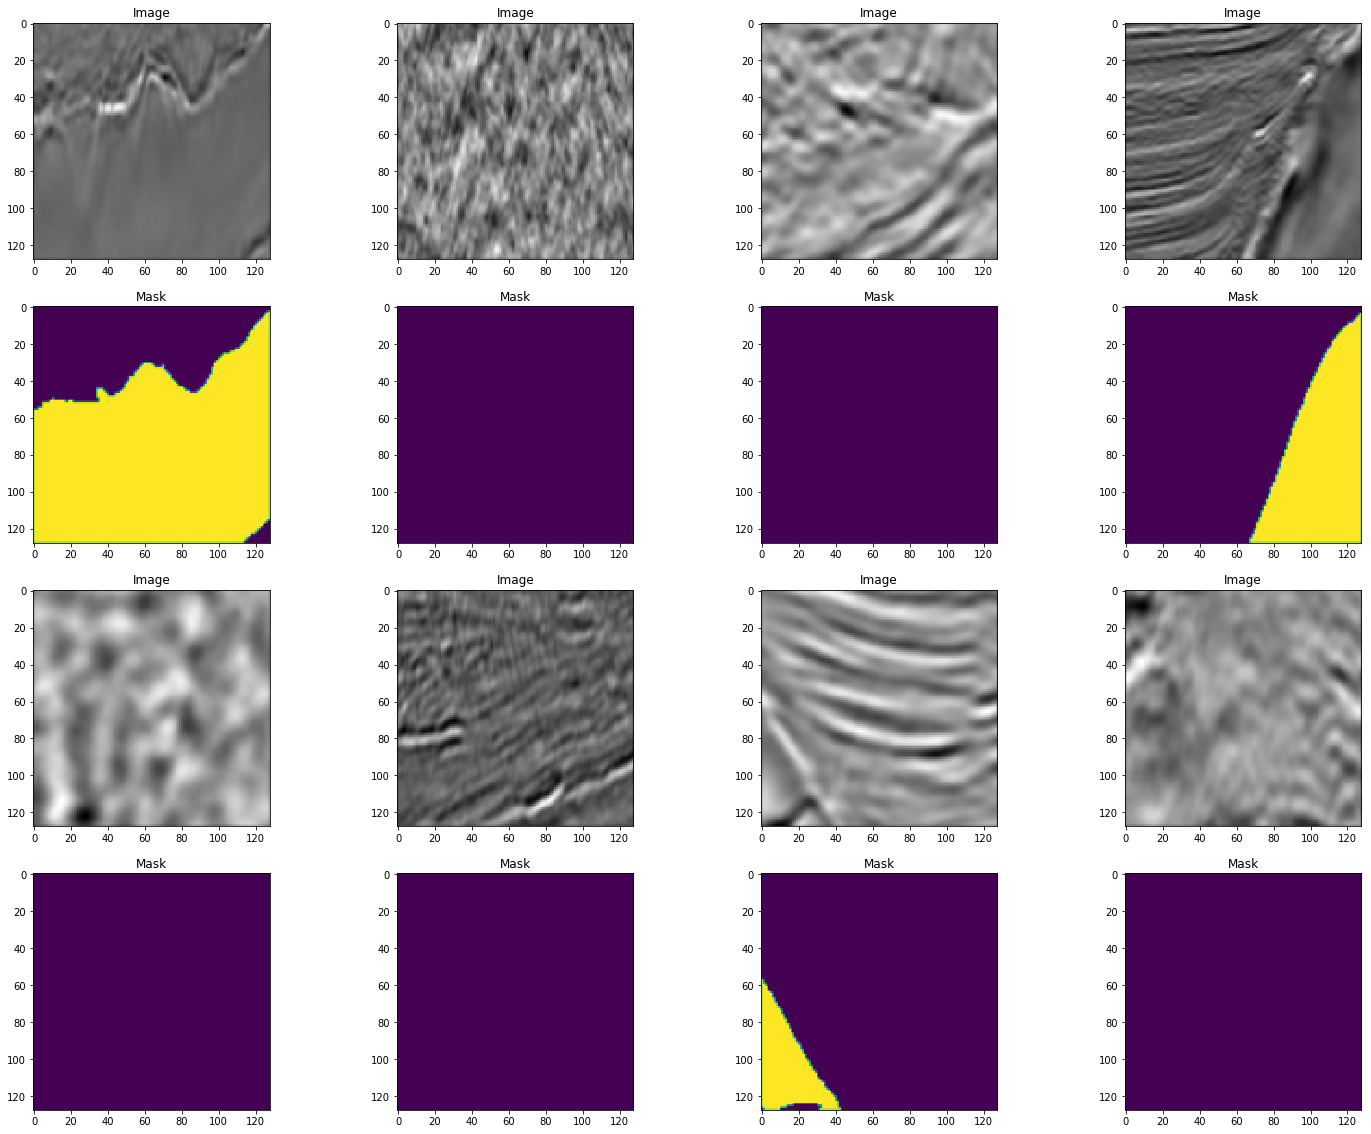

In [13]:
indices = np.random.choice(list(range(len(train_ids))), size=8)
plot_image_and_mask(indices)

In [14]:
indices = np.random.choice(list(range(len(train_ids))), size=8)
plot_image_and_mask(indices)

In [15]:
indices = np.random.choice(list(range(len(train_ids))), size=8)
plot_image_and_mask(indices)

In [16]:
indices = np.random.choice(list(range(len(train_ids))), size=8)
plot_image_and_mask(indices)

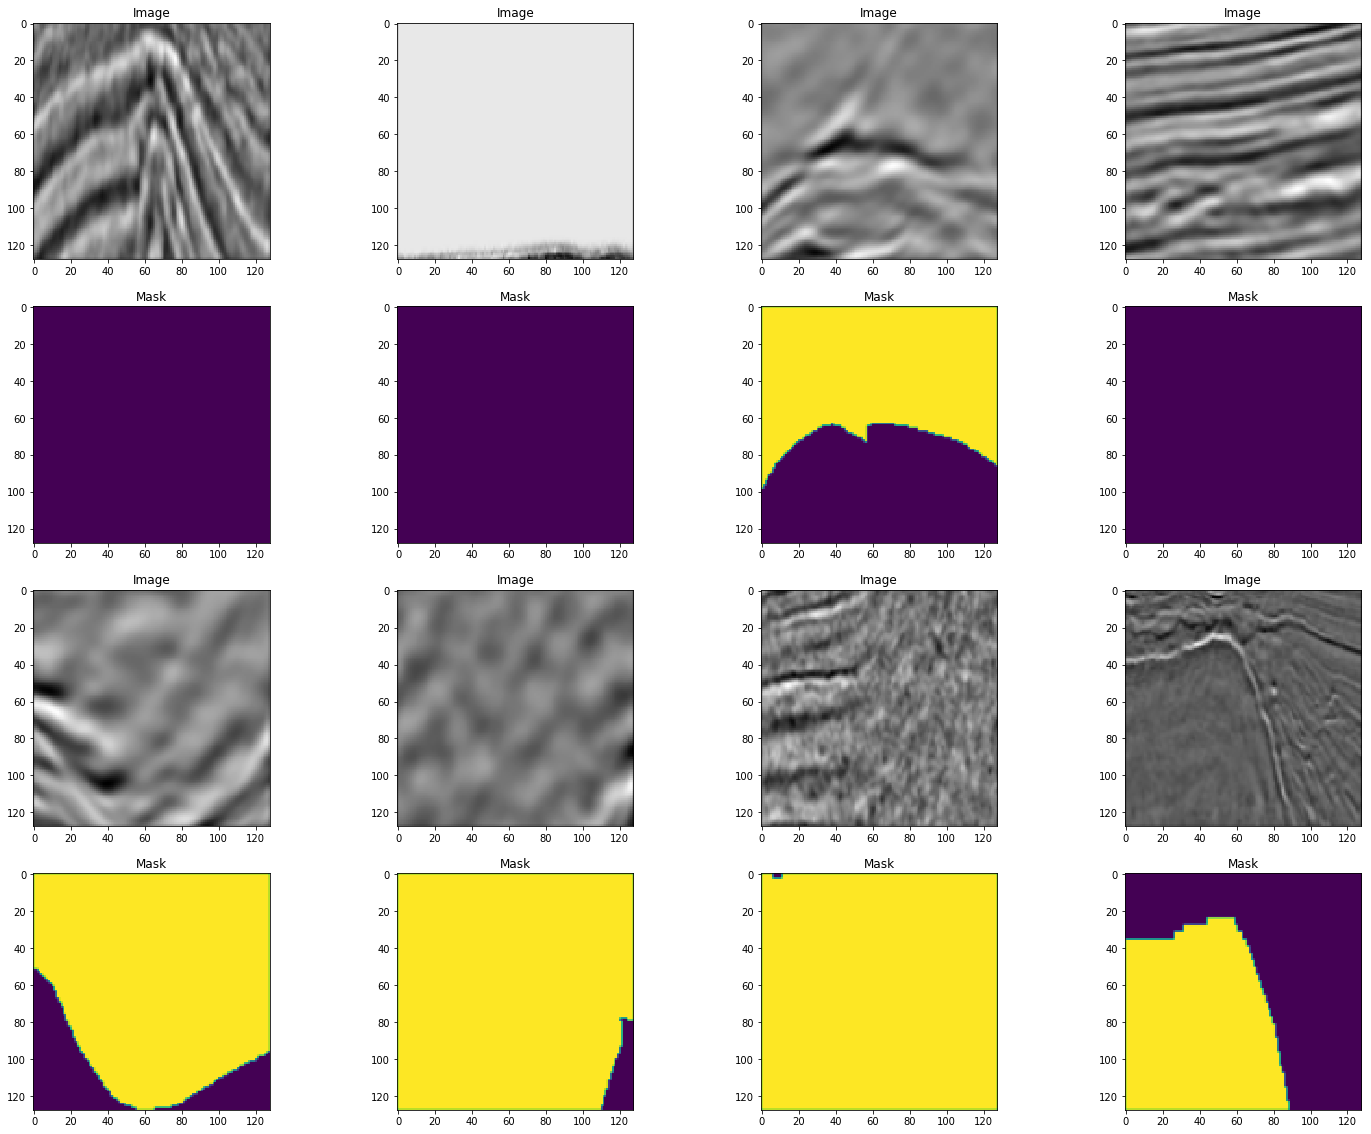

In [17]:
indices = np.random.choice(list(range(len(train_ids))), size=8)
plot_image_and_mask(indices)

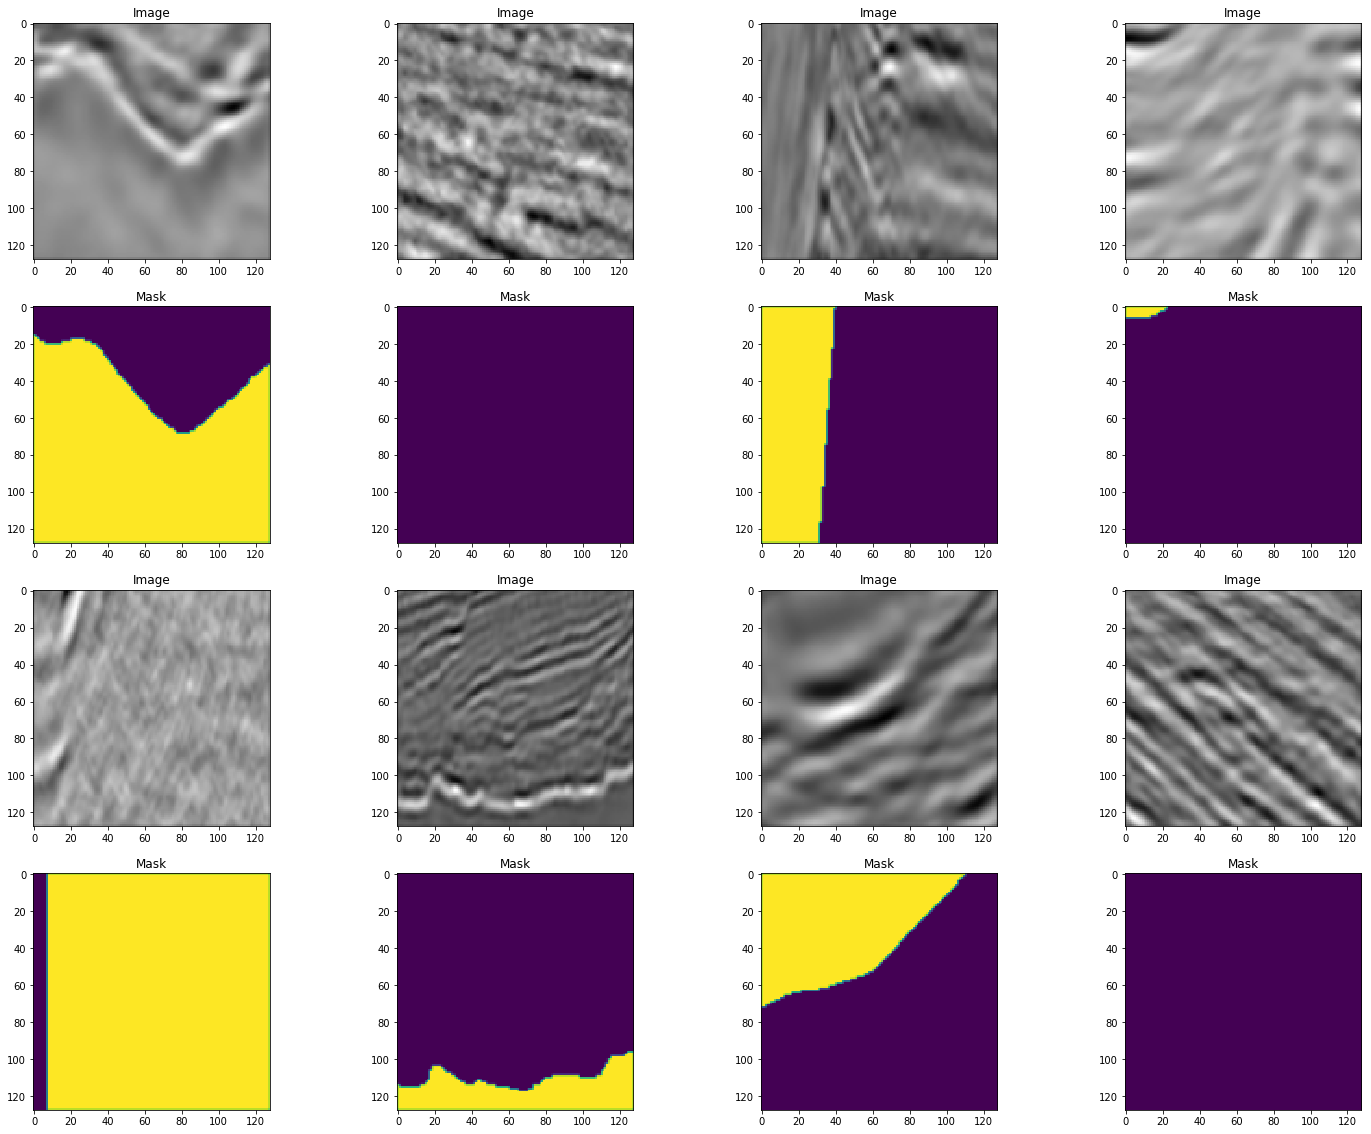

In [18]:
indices = np.random.choice(list(range(len(train_ids))), size=8)
plot_image_and_mask(indices)

In [19]:
indices = np.random.choice(list(range(len(train_ids))), size=8)
plot_image_and_mask(indices)

## 5. Create graph of U-Net

**Inspect the devices of kernel**

In [20]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
print(devices)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12206963457811122698
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15864515789
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3080736105475187068
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


**Set the device to gpu if available**

In [21]:
if len(devices)>1:
    device = devices[1].name
else:
    device = devices[0].name

**Reset the default graph**

In [22]:
tf.reset_default_graph()

**Create graph**

In [23]:
# kernel sizes of conv and deconv layers
kernel_sizes = [7,7,5,3]
# number of filters of each conv layer
conv_filters = [32,64,128,256]
# stride 
strides = 1
# max pool kernel size and strides
max_pool_kernel_size = 2
max_pool_strides = 2
# number of filters of each deconv layer 
conv_transpose_filters = [256,128,64,32]
learning_rate=0.0001*0.4
# batch size
batch_size = 200
# max iteration
max_iter = 7500
# Image Dimensions
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,IMG_HEIGHT_RESIZE,IMG_WIDTH_RESIZE,MASK_CHANNELS = 101, 101, 3, 128, 128,1
# create unet
model = unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,IMG_HEIGHT_RESIZE,IMG_WIDTH_RESIZE,MASK_CHANNELS,
             conv_filters, conv_transpose_filters, kernel_sizes, strides,
             max_pool_kernel_size, max_pool_strides, learning_rate, device, tf_rand_seed, np_rand_seed)

########################Layers of UNET########################
Tensor("conv2d/BiasAdd:0", shape=(?, 128, 128, 16), dtype=float32, device=/device:GPU:0)
Tensor("Elu:0", shape=(?, 128, 128, 16), dtype=float32, device=/device:GPU:0)
Tensor("batch_normalization/cond/Merge:0", shape=(?, 128, 128, 16), dtype=float32, device=/device:GPU:0)
Tensor("conv2d_1/BiasAdd:0", shape=(?, 128, 128, 16), dtype=float32, device=/device:GPU:0)
Tensor("Elu_1:0", shape=(?, 128, 128, 16), dtype=float32, device=/device:GPU:0)
Tensor("batch_normalization_1/cond/Merge:0", shape=(?, 128, 128, 16), dtype=float32, device=/device:GPU:0)
Tensor("max_pooling2d/MaxPool:0", shape=(?, 64, 64, 16), dtype=float32, device=/device:GPU:0)
Tensor("conv2d_2/BiasAdd:0", shape=(?, 64, 64, 32), dtype=float32, device=/device:GPU:0)
Tensor("Elu_2:0", shape=(?, 64, 64, 32), dtype=float32, device=/device:GPU:0)
Tensor("batch_normalization_2/cond/Merge:0", shape=(?, 64, 64, 32), dtype=float32, device=/device:GPU:0)
Tensor("conv2d_3/Bias

## 6. Train U-Net

**Train model**

In [24]:
# randomly generate train and validation indices
train_indices = np.random.choice(len(train_ids), round(len(train_ids)*0.95), replace=False)
validation_indices = np.array(list(set(range(len(train_ids))) - set(train_indices)))
print("Size of train set:", len(train_indices))
print("Size of validation set:", len(validation_indices))
# name of model
model_name = 'unet-salt-identification-challenge'
# arguments for train batch passed to the train method
args =(train_ids, TRAIN_IMG_DIR, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, MAX)
model.train_model(max_iter,batch_size,
                  train_indices,validation_indices,train_ids,
                  model_dir, model_name, generate_batch,*args)

Size of train set: 3800
Size of validation set: 200


[100%]||(train_cost:   0.62)(valid_cost:  0.624)(best_valid_cost:  0.614)(time_elapsed:    164mins)


**Plot of cost vs iterations**

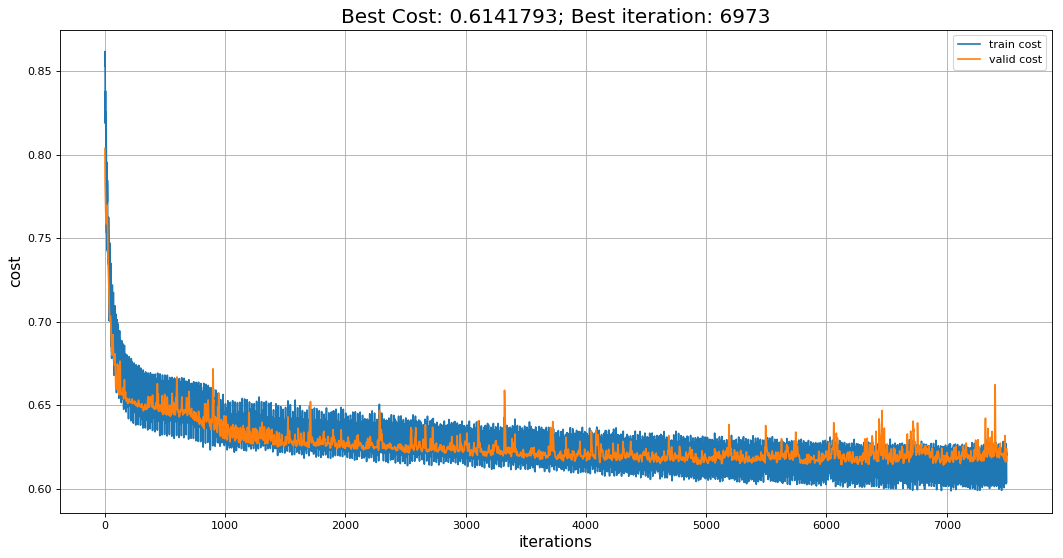

In [25]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(model.train_cost, label = 'train cost')
plt.plot(model.valid_cost, label = 'valid cost')
plt.xlabel('iterations', fontsize = 14)
plt.ylabel('cost', fontsize = 14)
plt.title("Best Cost: "+str(model.best_cost)+"; Best iteration: "+str(model.best_iteration),fontsize = 18)
plt.legend()
plt.grid()
plt.show()

## 7. Visualize sample predicted and corresponding original masks

**Compute predicted masks for validation set**

In [27]:
# generate batch of images and masks for validation set 
image_validation, mask_validation =  generate_batch(validation_indices, train_ids, TRAIN_IMG_DIR, 
                                                    IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, MAX, train_set=True)
# feed dict for validation set
feed_dict_validation =  {model.X: image_validation.astype(np.float32), model.Y: mask_validation.astype(np.float32), 
                         model.training: False, model.cond: np.array([0,0,0])}
# compute the predicted mask of the validation set
with tf.Session() as sess:
    # restore the best model
    model_path = model_dir+model_name+"-"+str(model.best_iteration)
    model.saver.restore(sess, model_path)
    # compute predicted masks
    mask_predicted = sess.run(model.Y_, feed_dict=feed_dict_validation)

INFO:tensorflow:Restoring parameters from ./model_files/unet-salt-identification-challenge-6973


**A function to plot sample predicted and original masks**

In [28]:
def plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices,treshold):
    
    '''
    A function to plot masks and corresponding predicted masks
    '''
    # squeeze arrays containing masks and predicted masks of validation set
    mask_predicted_squeezed = np.squeeze(mask_predicted[indices])
    mask_validation_squeezed = np.squeeze(mask_validation[indices].astype(np.float32))
    # binirize predicted masks
    mask_predicted_squeezed = binirize_mask(mask_predicted_squeezed, threshold = treshold)
    # plot the masks and corresponding predicted masks
    matplotlib.rcParams['figure.figsize'] = (25.0, 20.0)
    plt.subplot(4,4,1)
    plt.title("Original Mask")
    plt.imshow(mask_validation_squeezed[0])
    plt.subplot(4,4,1+4)
    plt.title("Predicted Mask")
    plt.imshow(mask_predicted_squeezed[0])
    plt.subplot(4,4,2)
    plt.title("Original Mask")
    plt.imshow(mask_validation_squeezed[1])
    plt.subplot(4,4,2+4)
    plt.title("Predicted Mask")
    plt.imshow(mask_predicted_squeezed[1].astype(np.uint8))
    plt.subplot(4,4,3)
    plt.title("Original Mask")
    plt.imshow(mask_validation_squeezed[2].astype(np.uint8))
    plt.subplot(4,4,3+4)
    plt.title("Predicted Mask")
    plt.imshow(mask_predicted_squeezed[2].astype(np.uint8))
    plt.subplot(4,4,4)
    plt.title("Original Mask")
    plt.imshow(mask_validation_squeezed[3].astype(np.uint8))
    plt.subplot(4,4,4+4)
    plt.title("Predicted Mask")
    plt.imshow(mask_predicted_squeezed[3].astype(np.uint8))
    plt.subplot(4,4,9)
    plt.title("Original Mask")
    plt.imshow(mask_validation_squeezed[4].astype(np.uint8))
    plt.subplot(4,4,1+12)
    plt.title("Predicted Mask")
    plt.imshow(mask_predicted_squeezed[4].astype(np.uint8))
    plt.subplot(4,4,10)
    plt.title("Original Mask")
    plt.imshow(mask_validation_squeezed[5].astype(np.uint8))
    plt.subplot(4,4,2+12)
    plt.title("Predicted Mask")
    plt.imshow(mask_predicted_squeezed[5].astype(np.uint8))
    plt.subplot(4,4,11)
    plt.title("Original Mask")
    plt.imshow(mask_validation_squeezed[6].astype(np.uint8))
    plt.subplot(4,4,3+12)
    plt.title("Predicted Mask")
    plt.imshow(mask_predicted_squeezed[6].astype(np.uint8))
    plt.subplot(4,4,12)
    plt.title("Original Mask")
    plt.imshow(mask_validation_squeezed[7].astype(np.uint8))
    plt.subplot(4,4,4+12)
    plt.title("Predicted Mask")
    plt.imshow(mask_predicted_squeezed[7].astype(np.uint8))
    plt.show()

**Generate indices and plot sample masks and predicted masks**

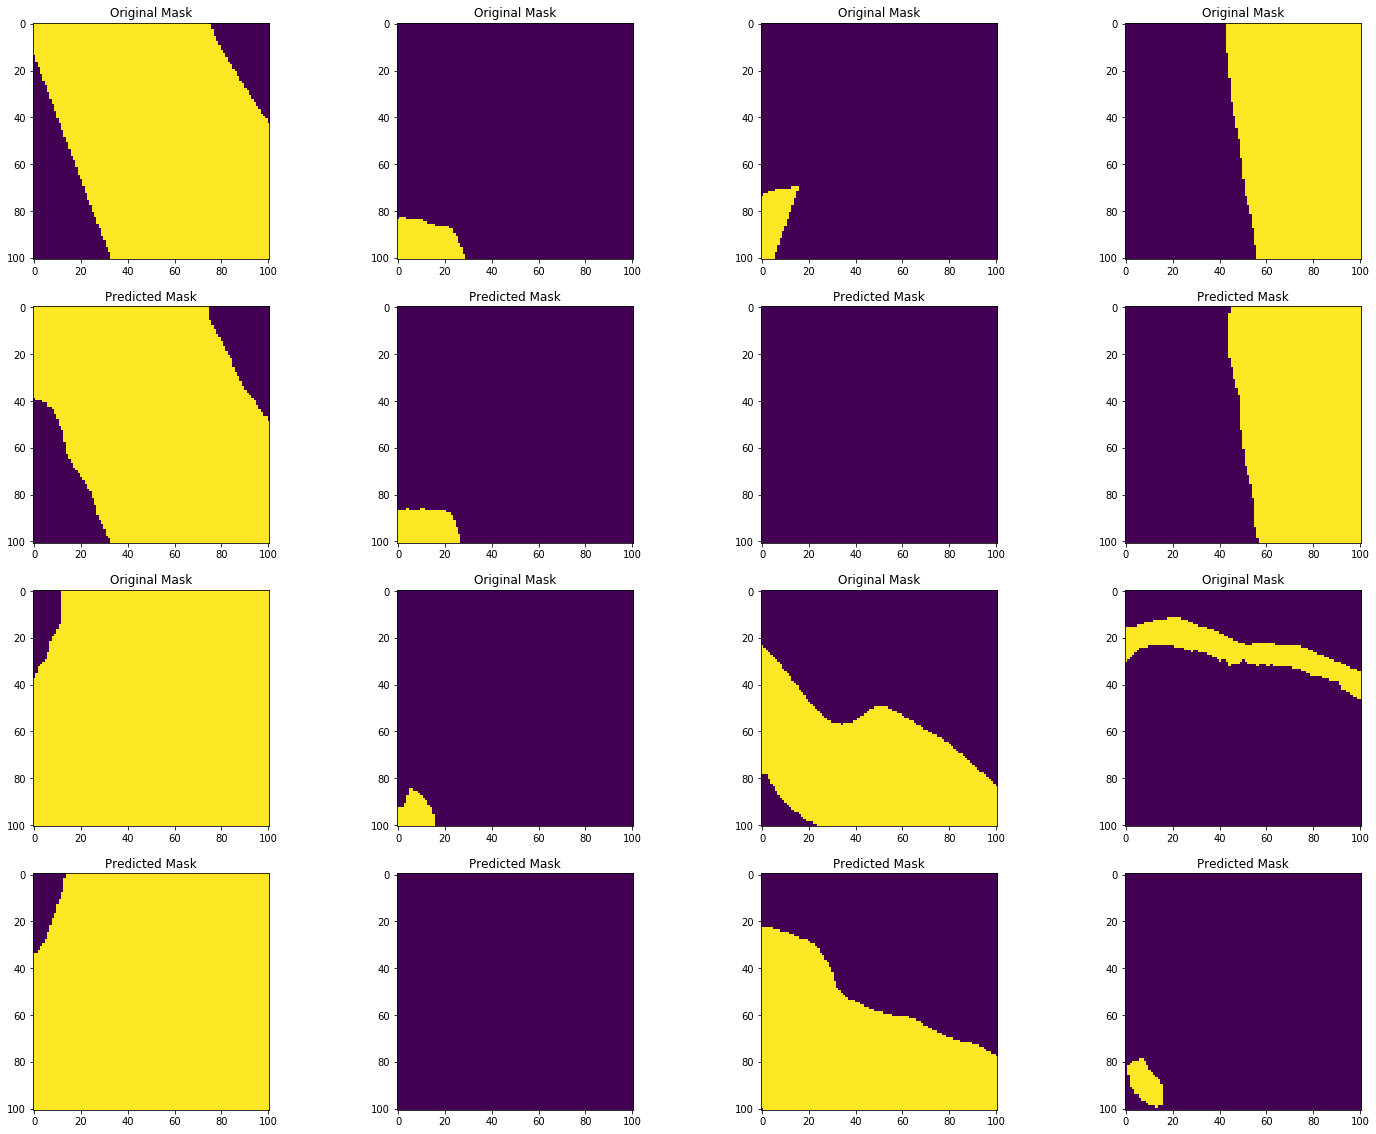

In [29]:
indices = np.array(list(range(0,8)))
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.5)

In [30]:
indices = np.array(list(range(8,16)))
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.5)

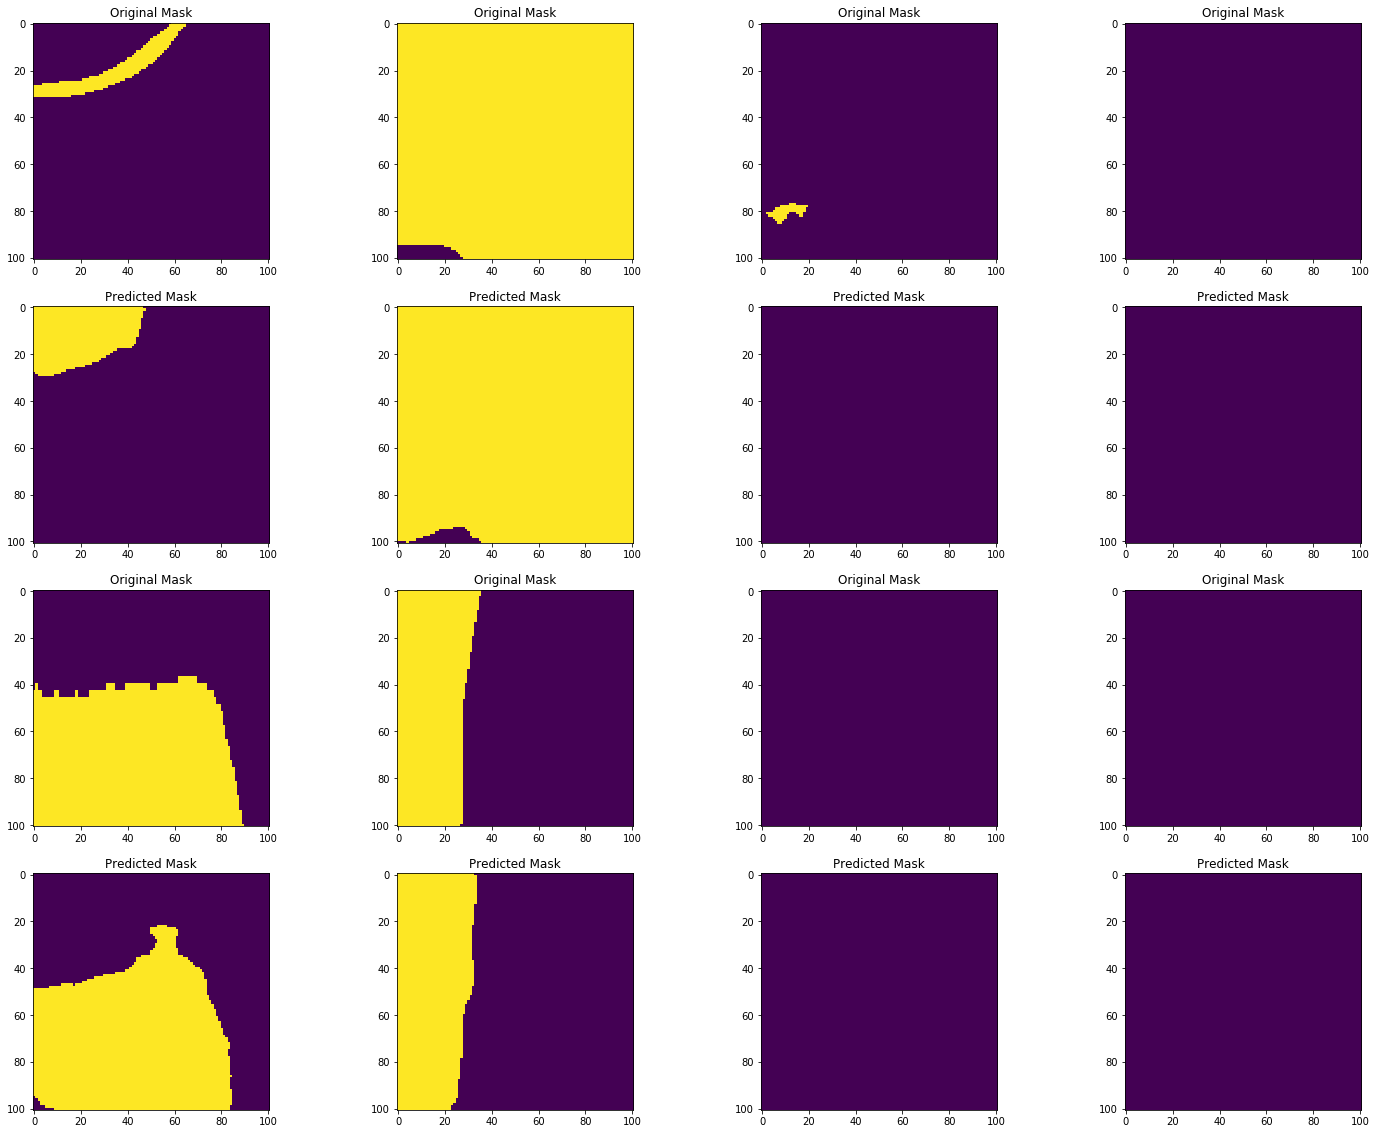

In [31]:
indices = np.array(list(range(16,24)))
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.5)

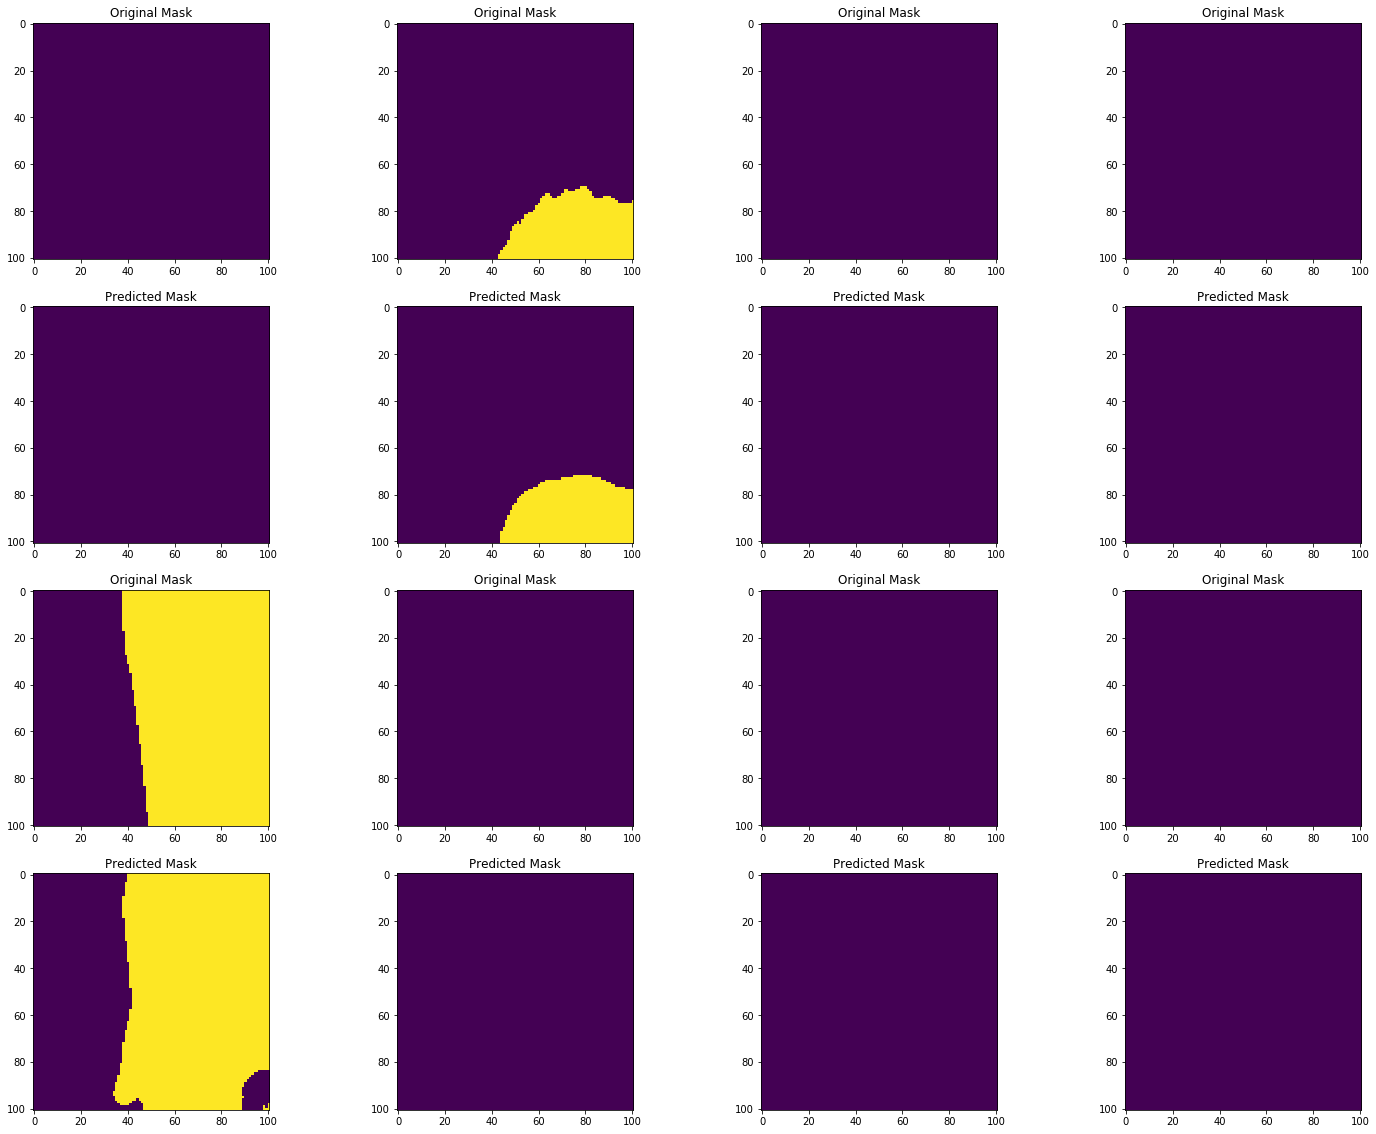

In [32]:
indices = np.array(list(range(24,32)))
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.5)

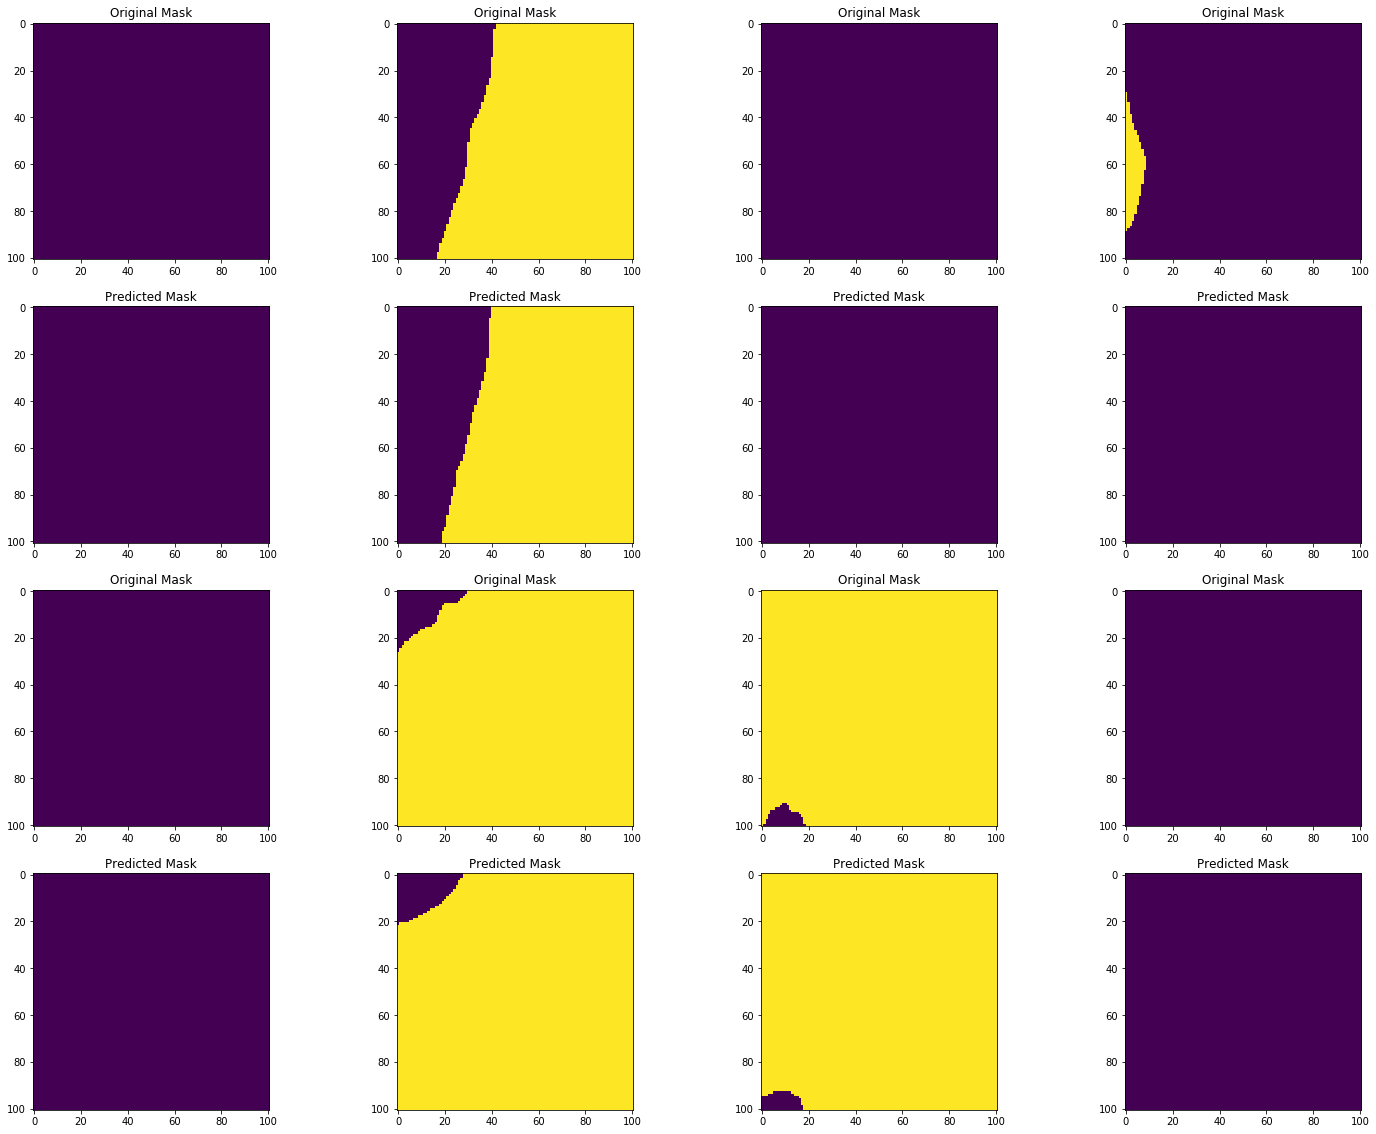

In [33]:
indices = np.array(list(range(32,40)))
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.5)

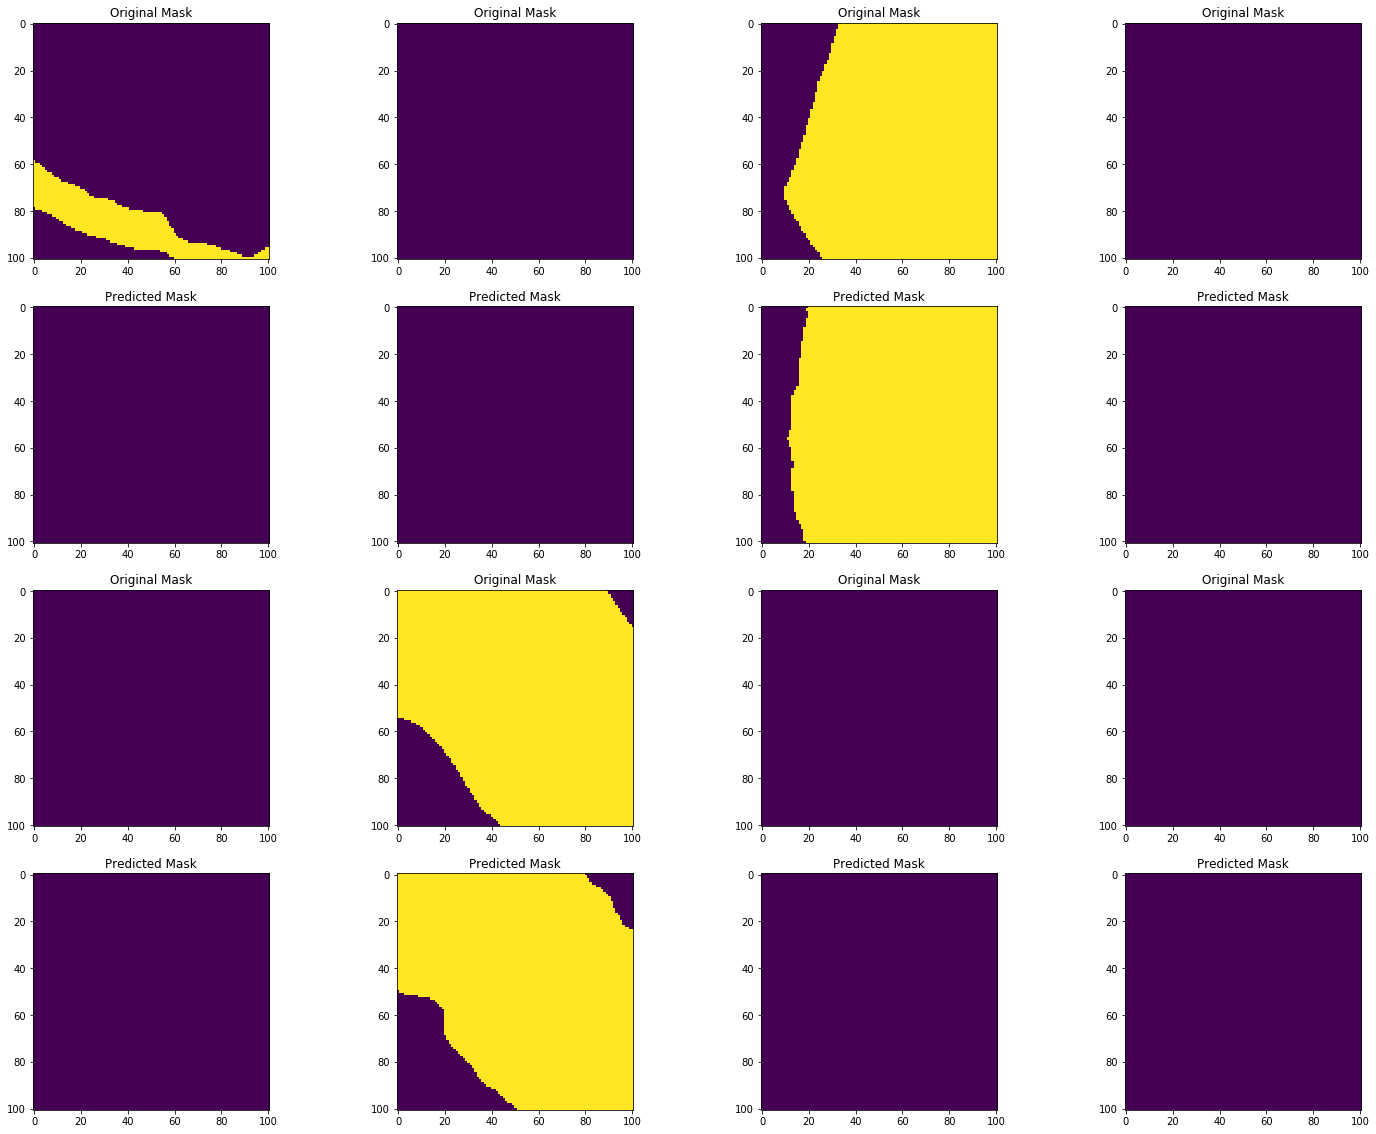

In [34]:
indices = np.array(list(range(40,48)))
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.5)

In [35]:
indices = np.array(list(range(38,56)))
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.5)

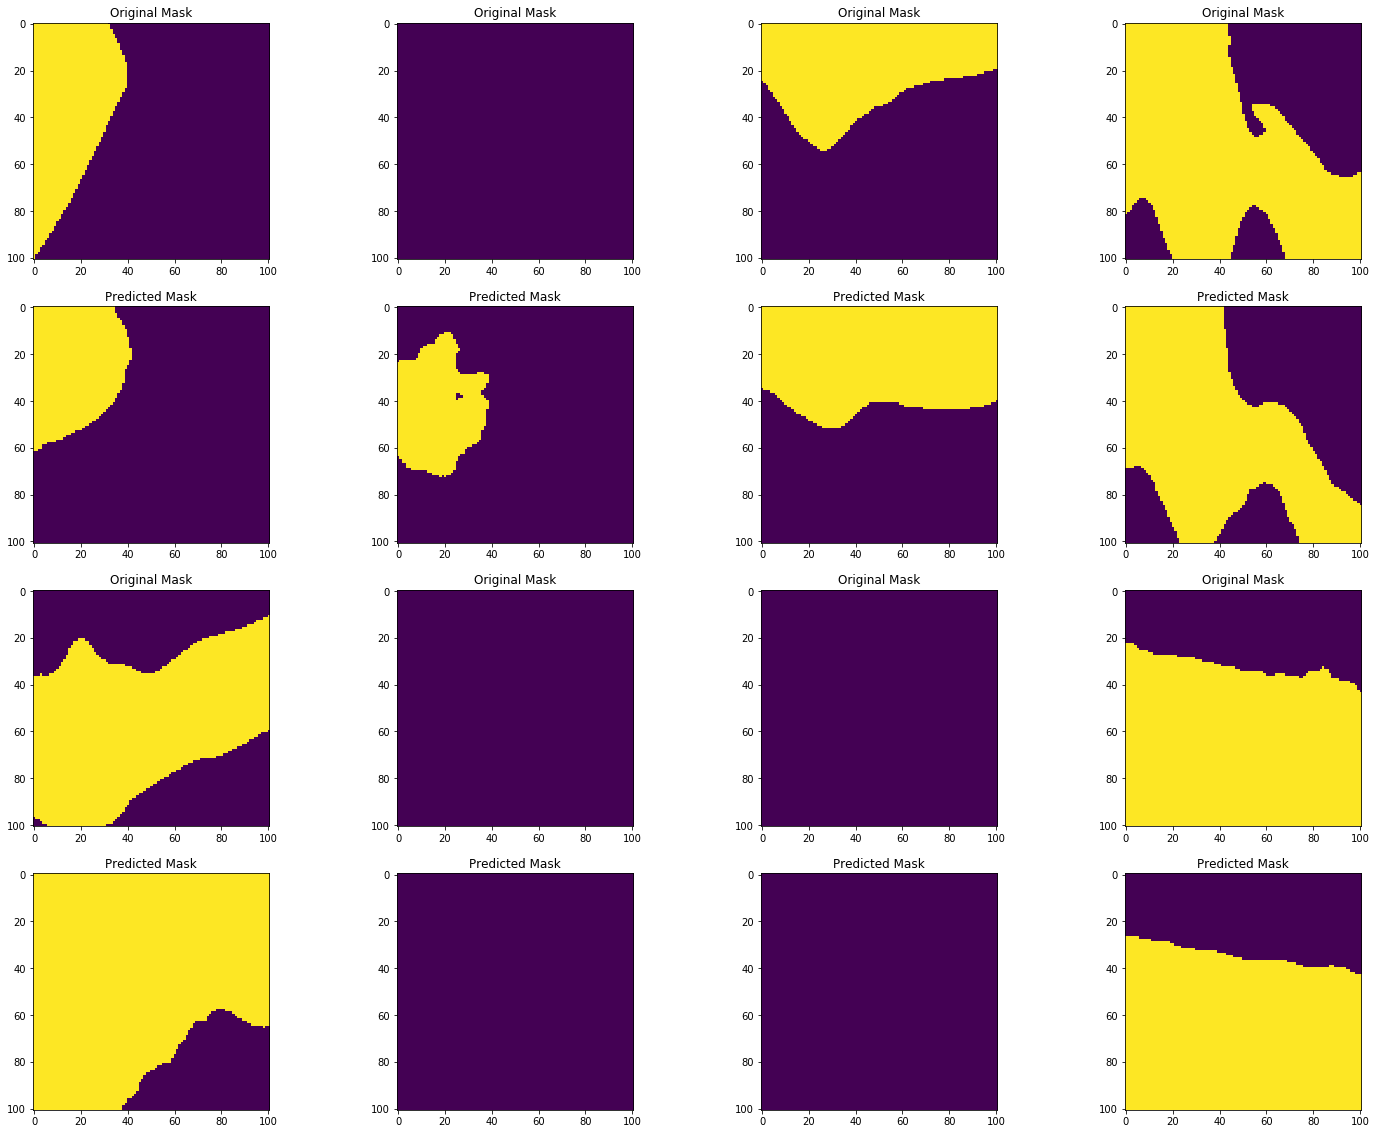

In [36]:
indices = np.array(list(range(56,64)))
plot_masks_and_predicted_masks(mask_validation, mask_predicted, indices, 0.5)

## 8. Analyse Results

**Print results**

In [37]:
print("Best validation cost:", model.best_cost)
print("Time to reach best validation cost:", model.best_time, "mins")
print("#iterations to reach best validation cost:", model.best_iteration)

Best validation cost: 0.6141793
Time to reach best validation cost: 152.95810867547988 mins
#iterations to reach best validation cost: 6973


**Compute intersection of union on validation set**

In [38]:
with tf.Session() as sess:
    # restore the best model
    model_path = model_dir+model_name+"-"+str(model.best_iteration)
    model.saver.restore(sess, model_path)
    # compute intersection of union on validation set
    intersection_of_union = sess.run(model.iou, feed_dict=feed_dict_validation)
print("IoU on validation set:",intersection_of_union)

INFO:tensorflow:Restoring parameters from ./model_files/unet-salt-identification-challenge-6973
IoU on validation set: 0.7070000000000002
